[*********************100%***********************]  1 of 1 completed


(                 WMA       RSI       ADO       ATR       SMA
 Date                                                        
 2017-04-13  0.780921  0.000000  0.624392  0.067345  0.791375
 2017-04-17  0.780320  0.350055  0.820581  0.074034  0.787026
 2017-04-18  0.777489  0.241874  0.409760  0.082283  0.783402
 2017-04-19  0.776374  0.312991  0.836586  0.076330  0.781227
 2017-04-20  0.781650  0.583062  0.821483  0.108874  0.783764
 ...              ...       ...       ...       ...       ...
 2020-09-24  0.266948  0.335891  0.661953  0.260450  0.266610
 2020-09-25  0.257211  0.275276  0.642278  0.252287  0.260691
 2020-09-28  0.252386  0.398525  0.854558  0.256088  0.255496
 2020-09-29  0.246552  0.358368  0.609300  0.237214  0.250181
 2020-09-30  0.242949  0.398415  0.773629  0.220227  0.245832
 
 [873 rows x 5 columns],
 Date
 2017-04-13    11.28
 2017-04-17    11.14
 2017-04-18    11.19
 2017-04-19    11.47
 2017-04-20    11.34
               ...  
 2020-09-24     6.51
 2020-09-25   

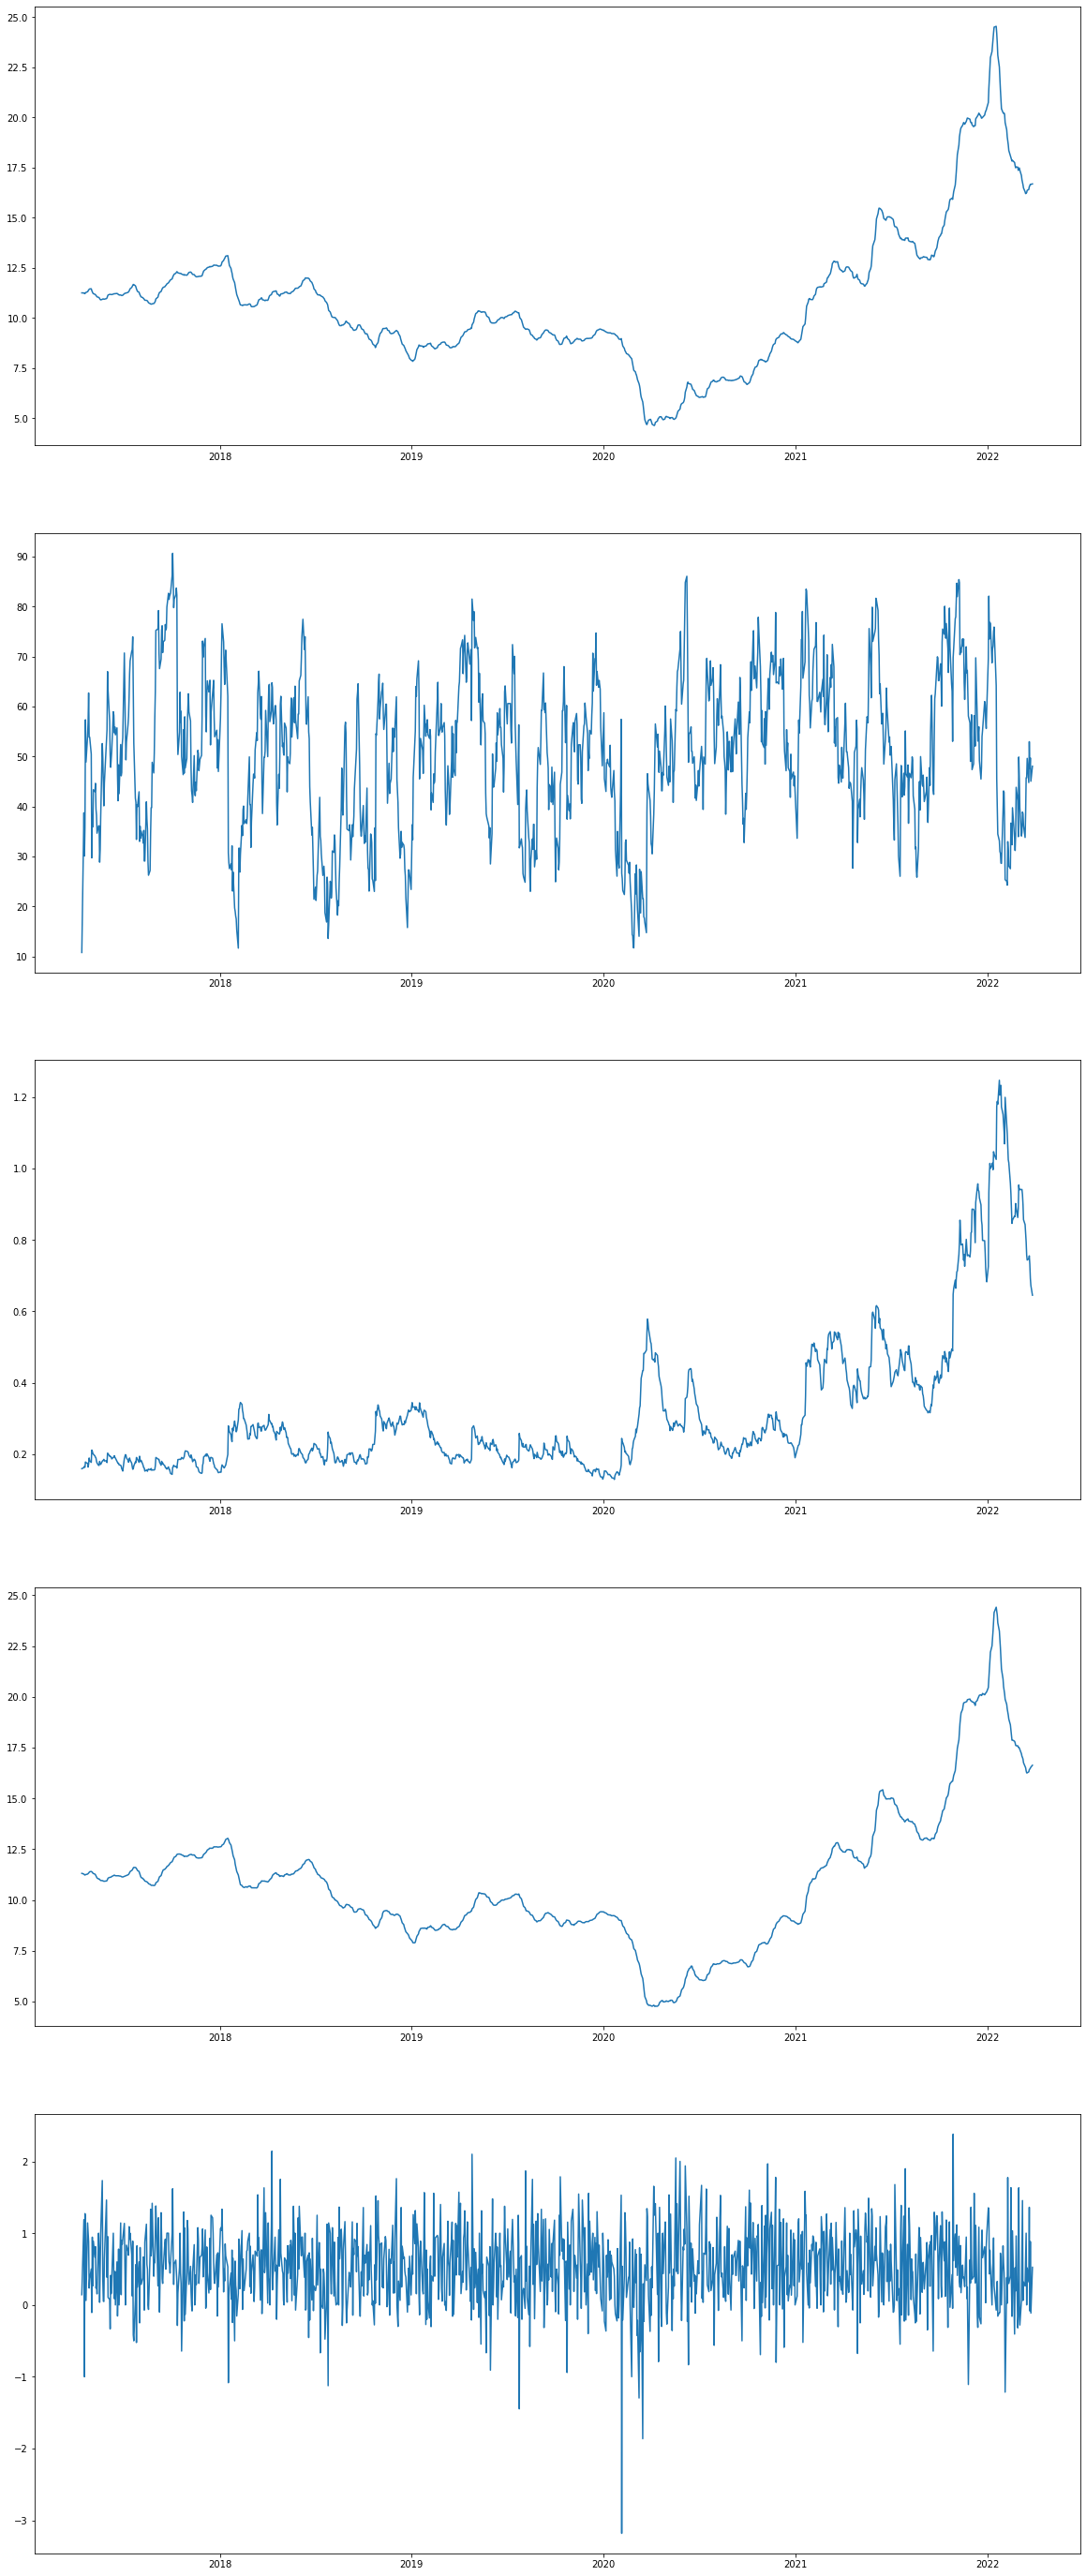

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from ta.trend import WMAIndicator
from ta.trend import SMAIndicator
from ta.momentum import RSIIndicator
from ta.volatility import AverageTrueRange
from ta.volume import AccDistIndexIndicator
from ta.utils import IndicatorMixin

class AccDistOscillatorIndicator(IndicatorMixin):
    def __init__(
        self,
        high: pd.Series,
        low: pd.Series,
        closeY: pd.Series,
        fillna: bool = False,
    ):
        
        self._high = high
        self._low = low
        self._closeY = closeY
        self._fillna = fillna
        self._run()
        
    def _run(self):
        ado = (self._high - self._closeY)/(self._high - self._low)
        self._ado = ado
        
    def acc_dist_oscillator(self) -> pd.Series:
        ado = self._check_fillna(self._ado, value=0)
        return pd.Series(ado, name="ado")

def acc_dist_oscillator(high, low, closeY, fillna=False):
    return AccDistOscillatorIndicator(high=high, low=low, closeY=closeY, fillna=fillna).acc_dist_oscillator()
    
def ticker_data_processing(ticker, time_period):
    tick = yf.download(ticker, period=time_period)
    tickerData = tick
    #adjusting the Adj Close columns 
    tickerData = tickerData.drop(['Adj Close'], axis =1)
    close = tickerData['Close']
    tickerData['Today Close'] = close
    tickerData['Close'] = tickerData['Close'].shift(-1)
    tickerData = tickerData.rename(columns={"Close" : "Tomorrow Close"})
    tickerData['Yesterday Close'] = tickerData['Today Close'].shift(+1)
    tickerData = tickerData.dropna()
    
    #using TA library to calculate and add TA data to the data set
    indicator_wma = WMAIndicator(close=tickerData["Today Close"], window = 10)
    tickerData['WMA'] = indicator_wma.wma()
    
    indicator_rsi = RSIIndicator(close=tickerData["Today Close"], window = 10)
    tickerData['RSI'] = indicator_rsi.rsi()
    
    indicator_atr = AverageTrueRange(high=tickerData["High"], low=tickerData["Low"], close=tickerData["Today Close"], window = 10)
    tickerData['ATR'] = indicator_atr.average_true_range()
    
    indicator_sma = SMAIndicator(close=tickerData["Today Close"], window = 10)
    tickerData['SMA'] = indicator_sma.sma_indicator()
    
    indicator_ado = AccDistOscillatorIndicator(high=tickerData["High"], low=tickerData["Low"], closeY=tickerData["Yesterday Close"])
    tickerData['ADO'] = indicator_ado.acc_dist_oscillator()
    
    tickerData = tickerData.drop(tickerData.index[:9])
   
    #print(tickerData) ##########################################################################
    
    #graphing the TA indicators
    fig, grph = plt.subplots(5, figsize =(20, 50))
    grph[0].plot(tickerData['WMA'])
    grph[1].plot(tickerData['RSI'])
    grph[2].plot(tickerData['ATR'])
    grph[3].plot(tickerData['SMA'])
    grph[4].plot(tickerData['ADO'])
    
    #drops N/A
    tickerData = tickerData.dropna()
    tickerData = tickerData.drop(['Volume', 'Open', 'High', 'Low', 'Today Close'], axis=1)
    
    #splitting the test and train data and dropping volume from both
    train_set, test_set = train_test_split(tickerData, test_size=0.3, shuffle=False)
    
    #setting up the scaler
    scale = ['WMA', 'RSI', 'ADO', 'ATR', 'SMA']
    scaler = MinMaxScaler()
    
    #seperate features and labels
    train_set_features = train_set.drop(["Tomorrow Close"], axis=1) 
    train_set_labels = train_set['Tomorrow Close'].copy()
    
    test_set_features = test_set.drop(['Tomorrow Close'], axis=1)
    test_set_labels = test_set['Tomorrow Close'].copy()
    
    #scaling the features
    feature_transform = scaler.fit_transform(train_set_features[scale])
    train_prepared = pd.DataFrame(columns=scale, data=feature_transform, index=train_set_features.index)
    
    feature_transform = scaler.transform(test_set_features[scale])
    test_prepared = pd.DataFrame(columns=scale, data=feature_transform, index=test_set_features.index)
    
    
    return train_prepared, train_set_labels, test_prepared, test_set_labels 

ticker_data_processing('F', '5y')

[*********************100%***********************]  1 of 1 completed
Scores: [0.39398006 0.36277202 0.29043619 0.27536774 0.27642004]
Mean: 0.3197952097982829
Standared deviation: 0.049127499358954434
MAPE:  0.024225800836674898


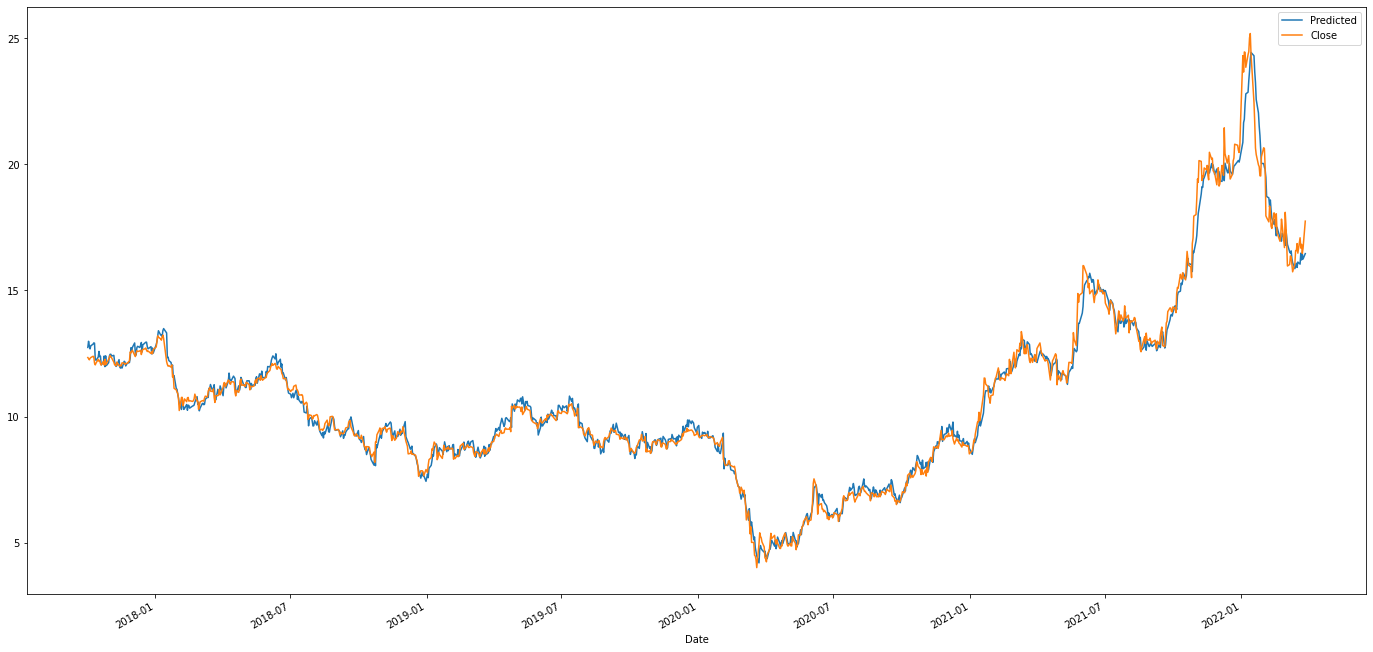

In [4]:
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_absolute_percentage_error

def svr_linear(ticker, period):
    train_prepared, train_set_labels, test_prepared, test_set_labels = ticker_data_processing(ticker, period)
    plt.close()
    svm_reg = SVR(kernel="linear" epsilon= .5, max_iter=2500)
    svm_reg.fit(train_prepared, train_set_labels)
    
    predictions = svm_reg.predict(test_prepared)
    
    scores = cross_val_score(svm_reg, train_prepared, train_set_labels, scoring="neg_mean_squared_error", cv=5 )
    
    rmse = np.sqrt(-scores)
    print("Scores:", rmse)
    print("Mean:", rmse.mean())
    print ("Standared deviation:", rmse.std())
    print("MAPE: ", mean_absolute_percentage_error(test_set_labels, predictions))
    
    
    test_prepared['Predicted Close'] = predictions.tolist()
    test_prepared['Predicted Close'].plot(label="Predicted", figsize=(24,12))
    test_set_labels.plot(label="Close")
    plt.legend()
    
svr_linear('F', '15y')

In [ ]:
from sklearn.svm import SVR

def svr_polynomial(ticker, period):
    train_prepared, train_set_labels, test_prepared, test_set_labels = ticker_data_processing(ticker, period)
    plt.close()
    svm_reg = SVR(kernel= 'poly', epsilon= .5, max_iter=2500)
    svm_reg.fit(train_prepared, train_set_labels)
    
    predictions = svm_reg.predict(test_prepared)
    
    scores = cross_val_score(svm_reg, train_prepared, train_set_labels, scoring="neg_mean_squared_error", cv=5 )
    
    rmse = np.sqrt(-scores)
    print("Scores:", rmse)
    print("Mean:", rmse.mean())
    print ("Standared deviation:", rmse.std())
    print("MAPE: ", mean_absolute_percentage_error(test_set_labels, predictions))
    
    
    test_prepared['Predicted Close'] = predictions.tolist()
    test_prepared['Predicted Close'].plot(label="Predicted", figsize=(24,12))
    test_set_labels.plot(label="Close")
    plt.legend()
    
svr_polynomial('F', '5y')

In [ ]:
def svr_rbf(ticker, period):
    train_prepared, train_set_labels, test_prepared, test_set_labels = ticker_data_processing(ticker, period)
    plt.close()
    svm_reg = SVR(kernel= 'rbf', epsilon= .5, max_iter=2500)
    svm_reg.fit(train_prepared, train_set_labels)
    
    predictions = svm_reg.predict(test_prepared)
    
    scores = cross_val_score(svm_reg, train_prepared, train_set_labels, scoring="neg_mean_squared_error", cv=5 )
    
    rmse = np.sqrt(-scores)
    print("Scores:", rmse)
    print("Mean:", rmse.mean())
    print ("Standared deviation:", rmse.std())
    print("MAPE: ", mean_absolute_percentage_error(test_set_labels, predictions))
    
    
    test_prepared['Predicted Close'] = predictions.tolist()
    test_prepared['Predicted Close'].plot(label="Predicted", figsize=(24,12))
    test_set_labels.plot(label="Close")
    plt.legend()
    
svr_rbf('F', '5y')

In [ ]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error

def randomWalk(ticker, period):
    plt.close()
    tick = yf.download(ticker, period=period)
    tickerData = tick

    returns = tickerData['Close'].pct_change() #calculates the daily returns of the stock as a percentage
    daily_volatility = returns.std() #calculates the standard deviation of the stock returns to represent sigma in random walk eq.
    
    index = tickerData.index
    length = len(index)
    count = 0
    predicted_prices = []
    last_price = tickerData['Close'][0]

    price = last_price #sets the initial price
    predicted_prices.append(price) 
    
    for y in range(length): #for loop runs for the length of time given
        if count == length-1:
            break
        price = predicted_prices[count] * (1 + np.random.normal(0, daily_volatility)) #calculates prices with random walk equation
        predicted_prices.append(price) #adds price to list
        count += 1
        
    actualPrice = tickerData.Close 
    rmse = mean_squared_error(actualPrice, predicted_prices, squared = False)
    print("MAPE: ", mean_absolute_percentage_error(actualPrice, predicted_prices))
    print("RMSE: ", rmse)
    
    df = pd.DataFrame(predicted_prices)
    df.index = tickerData.index
    
    ax = df.plot()
    tickerData['Close'].plot(label="Close", ax=ax,figsize=(15,7),grid=True)
    
    
randomWalk('HL', '1y')

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf

from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer
from skopt.plots import plot_objective, plot_histogram

linear = BayesSearchCV(
    SVR(),
    {
        'C': (1e-6, 1e+6, 'log-uniform'),
        'kernel': ['linear'],  # categorical parameter
    },
    n_iter=1000,
    cv=2,
    random_state = 1
)

rbf = BayesSearchCV(
    SVR(),
    {
        'C': (1e-6, 1e+6, 'log-uniform'),
        'gamma': (1e-6, 1e+6, 'log-uniform'),
        'kernel': ['rbf'],  # categorical parameter
    },
    n_iter=1000,
    cv=2,
    random_state = 1
)
poly = BayesSearchCV(
    SVR(),
    {
        'C': (1e-6, 1e+6, 'log-uniform'),
        'gamma': (1e-6, 1e+6, 'log-uniform'),
        'degree': (1e-6, 1e+6, 'log-uniform'),
        'kernel': ['poly'],  # categorical parameter
    },
    n_iter=1000,
    cv=2,
    random_state = 1
)
train_x, train_y, test_x, test_y = ticker_data_processing('F', '5y')
model = linear.fit(train_x, train_y)
print(linear.score(test_x, test_y))